## Installing Libraries



In [1]:
!pip install -q datasets

## Using TPU Cores

In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  #TPUClusterResolver is used to find the cluster in which TPUs are located.
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
#This line of code connects TensorFlow to the TPU cluster specified by the tpu object created earlier.
tf.tpu.experimental.initialize_tpu_system(tpu)
#This step initializes the TPU system and makes it ready for use.
tpu_strategy = tf.distribute.TPUStrategy(tpu)
#Speeds up training by distributing the model across multiple TPU cores.

Tensorflow version 2.16.2


BaseException: ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Reading Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('classification.csv')
df

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist
...,...,...
14479,find a tv series called armageddon summer,SearchCreativeWork
14480,find politicsnation with al sharpton,SearchCreativeWork
14481,rate this album 0 points out of 6,RateBook
14482,add leah kauffman to my uncharted 4 nathan dra...,AddToPlaylist


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14484 entries, 0 to 14483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14484 non-null  object
 1   intent  14484 non-null  object
dtypes: object(2)
memory usage: 226.4+ KB


In [ ]:
print('df size :', df.shape)

df size : (14484, 2)


In [ ]:
sum(df.duplicated())

# There are 268 duplicated rows in corpus

268

In [ ]:
df=df.drop_duplicates()

# we remove the duplicated rows

In [ ]:
df.isnull().sum()

# There aren't missing values

,0
text,0
intent,0


In [ ]:
df.reset_index(drop=True, inplace=True)

# We reset the index because we remove duplicated rows.

In [ ]:
df.intent.value_counts()

,count
intent,
GetWeather,2086
BookRestaurant,2068
PlayMusic,2064
SearchCreativeWork,2051
AddToPlaylist,2035
RateBook,1991
SearchScreeningEvent,1921


In [ ]:
df.intent.value_counts(normalize=True)

,proportion
intent,
GetWeather,0.146736
BookRestaurant,0.145470
PlayMusic,0.145189
SearchCreativeWork,0.144274
AddToPlaylist,0.143149
RateBook,0.140053
SearchScreeningEvent,0.135129


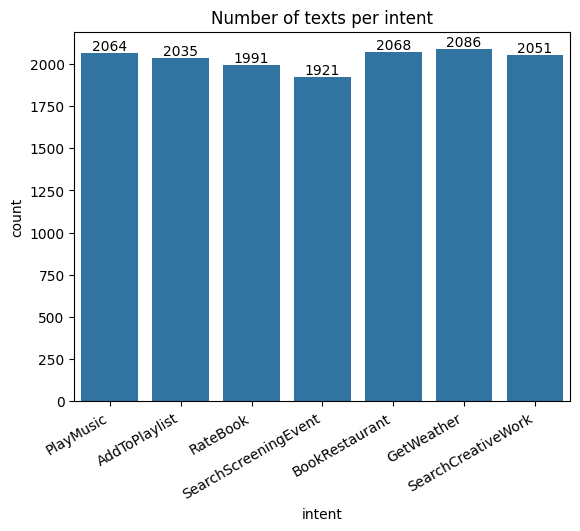

In [ ]:
chart = sns.countplot(x= "intent", data=df)
chart.bar_label(chart.containers[0])
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [ ]:
unique_labels=df.intent.unique()
unique_labels

array(['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent',
       'BookRestaurant', 'GetWeather', 'SearchCreativeWork'], dtype=object)

In [ ]:
label_dict= {j:i for i, j in enumerate(unique_labels)}
label_dict

{'PlayMusic': 0,
 'AddToPlaylist': 1,
 'RateBook': 2,
 'SearchScreeningEvent': 3,
 'BookRestaurant': 4,
 'GetWeather': 5,
 'SearchCreativeWork': 6}

In [ ]:
df.intent=df.intent.map(label_dict)

In [ ]:
X = df['text']
y = df['intent']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

## Max Text Length

## [Pre-trained model Classification](https://huggingface.co/docs/transformers/tasks/sequence_classification)

### [BERT Base Uncased](https://huggingface.co/google-bert/bert-base-uncased)

In [ ]:
# For every sentence...
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

number_tokens_sentences = []
for sent in X_train:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    input_ids = tokenizer.encode(str(sent),
                                 add_special_tokens=True)

    number_tokens_sentences.append(len(input_ids))

print('Max sentence length: ', max(number_tokens_sentences))

# We will use tokenizer.encode() function only to find out how many tokens the longest comment consists
# of and to decide how many tokens we will fix all comments/texts to.

# ATTENTION: If you get a "Your session has crashed for an unknown reason" warning when you first run this code block,
# first run this cell again and see if you get an error. Then run the notebook again from the first line.

Max sentence length:  38


In [ ]:
sentence=" how are you ?"

tokenizer.encode(str(sentence),
                 add_special_tokens=True)

[101, 2129, 2024, 2017, 1029, 102]

In [ ]:
tokenizer.decode([101, 2129, 2024, 2017, 1029, 102])

'[CLS] how are you? [SEP]'

In [ ]:
sum(np.array(number_tokens_sentences) <= 38) / len(number_tokens_sentences)

1.0

## Converting Data to Dataset Format

In [ ]:
#[{'text': '......', 'label': 0}]

In [ ]:
train_text=[]
for i, j in zip(X_train, y_train):
  train_text.append({"text": str(i), "label":j})

test_text=[]
for i, j in zip(X_test, y_test):
  test_text.append({"text": str(i), "label":j})

In [ ]:
train_text[0:2]

[{'text': 'find me a bar in eagle pass  vermont that serves noodle dishes  that will take reservations for 2/21/2021',
  'label': 4},
 {'text': 'i d like to book a table at a restaurant for a group of 4',
  'label': 4}]

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_list(train_text)
test_dataset = Dataset.from_list(test_text)

In [ ]:
train_dataset[:2]

{'text': ['find me a bar in eagle pass  vermont that serves noodle dishes  that will take reservations for 2/21/2021',
  'i d like to book a table at a restaurant for a group of 4'],
 'label': [4, 4]}

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 12794
})

## Tokenization

In [ ]:
sentence="How are you?"

tokenized_data = tokenizer(text=sentence,
                           return_tensors="np",
                           padding="max_length",
                           truncation=True,
                           max_length=7,
                           add_special_tokens=True)
tokenized_data

{'input_ids': array([[ 101, 2129, 2024, 2017, 1029,  102,    0]]), 'token_type_ids': array([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1, 0]])}

In [ ]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def transformation(examples):
  seq=38
  tokenized_data = tokenizer(text=examples["text"],
                             return_tensors="np",
                             padding="max_length",
                             truncation=True,
                             max_length=seq,
                             add_special_tokens=True)
  return tokenized_data

train_tokenized_data = train_dataset.map(transformation, batched=True)
test_tokenized_data = test_dataset.map(transformation, batched=True)

Map:   0%|          | 0/12794 [00:00<?, ? examples/s]

Map:   0%|          | 0/1422 [00:00<?, ? examples/s]

In [ ]:
train_tokenized_data

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 12794
})

In [ ]:
test_tokenized_data

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1422
})

In [ ]:
train_tokenized_data["input_ids"][:2]

[[101,
  2424,
  2033,
  1037,
  3347,
  1999,
  6755,
  3413,
  8839,
  2008,
  4240,
  2053,
  26156,
  10447,
  2008,
  2097,
  2202,
  17829,
  2005,
  1016,
  1013,
  2538,
  1013,
  25682,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [101,
  1045,
  1040,
  2066,
  2000,
  2338,
  1037,
  2795,
  2012,
  1037,
  4825,
  2005,
  1037,
  2177,
  1997,
  1018,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]]

## Create Optimizer and Training with TPU Cores

In [ ]:
len(train_tokenized_data["input_ids"])//32

399

In [ ]:
from transformers import create_optimizer

batch_size = 32 # 16
num_train_epochs = 4 # 3, 4
num_train_steps = (len(train_tokenized_data["input_ids"]) // batch_size) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
                                          init_lr=2e-5, #3e-5, 5e-5
                                          num_train_steps=num_train_steps,
                                          weight_decay_rate=0.01, # Weight reduction rate
                                          num_warmup_steps=0.1) # Number of warm-up steps

In [ ]:
optimizer

In [ ]:
lr_schedule.get_config()

{'initial_learning_rate': 2e-05,
 'decay_schedule_fn': <tf_keras.src.optimizers.schedules.learning_rate_schedule.PolynomialDecay at 0x7b97d8cdc350>,
 'warmup_steps': 0.1,
 'power': 1.0,
 'name': None}

In [ ]:
optimizer.get_config()

{'name': 'AdamWeightDecay',
 'learning_rate': {'module': 'transformers.optimization_tf',
  'class_name': 'WarmUp',
  'config': {'initial_learning_rate': 2e-05,
   'decay_schedule_fn': {'module': 'keras.optimizers.schedules',
    'class_name': 'PolynomialDecay',
    'config': {'initial_learning_rate': 2e-05,
     'decay_steps': 1595.9,
     'end_learning_rate': 0.0,
     'power': 1.0,
     'cycle': False,
     'name': None},
    'registered_name': None},
   'warmup_steps': 0.1,
   'power': 1.0,
   'name': None},
  'registered_name': 'WarmUp'},
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-08,
 'amsgrad': False,
 'weight_decay_rate': 0.01}

In [ ]:
with tpu_strategy.scope():

    from transformers import TFAutoModelForSequenceClassification

    # Load and compile our model
    model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                 num_labels=7)


    model.compile(optimizer=optimizer, metrics=["accuracy"])  # No loss argument!

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tf_dataset_train = model.prepare_tf_dataset(train_tokenized_data, batch_size=32, shuffle=False)
tf_dataset_test = model.prepare_tf_dataset(test_tokenized_data, batch_size=32, shuffle=False)

In [ ]:
tf_dataset_train

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 38), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 38), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 38), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
model.fit(tf_dataset_train,
          validation_data=(tf_dataset_test),
          epochs=num_train_epochs) #class_weight={0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1}

Epoch 1/4
400/400 [==============================] - 108s 112ms/step - loss: 0.3267 - accuracy: 0.9300 - val_loss: 0.0636 - val_accuracy: 0.9810
Epoch 2/4
400/400 [==============================] - 33s 83ms/step - loss: 0.0406 - accuracy: 0.9910 - val_loss: 0.0665 - val_accuracy: 0.9817
Epoch 3/4
400/400 [==============================] - 33s 83ms/step - loss: 0.0226 - accuracy: 0.9952 - val_loss: 0.0625 - val_accuracy: 0.9838
Epoch 4/4
400/400 [==============================] - 33s 83ms/step - loss: 0.0131 - accuracy: 0.9979 - val_loss: 0.0610 - val_accuracy: 0.9838


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
Total params: 109487623 (417.66 MB)
Trainable params: 109487623 (417.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Evaluation

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.326693,0.929967,0.063604,0.981013
1,0.040591,0.991011,0.066474,0.981716
2,0.022552,0.995154,0.062471,0.983826
3,0.013135,0.997890,0.061029,0.983826


<Axes: >

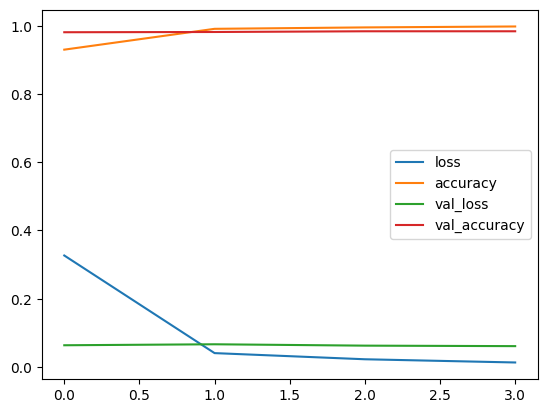

In [ ]:
model_loss.plot()

The term "logits" is a term often used in deep learning models and neural networks. Logits refer to the raw scores that come out of the last layer of the model, usually before a linear transformation and an activation function.

In a classification problem, logits outputs are usually interpreted as follows:

- **Multi-class classification**: Raw scores calculated by the model for different classes. These scores are converted to probabilities, usually by applying the softmax function.

- **Binary classification**: Raw scores used to determine the decision boundary between two classes. These scores are converted to probabilities by using the sigmoid function.

To understand logits values, you can follow these steps:
1. **Softmax Application**: You can use the softmax function to convert logits values ​​to probabilities. This ensures that the sum of the probabilities for each class is 1.

2. **Prediction**: The class with the highest probability is selected as the model's prediction.

In [ ]:
logits= model.predict(tf_dataset_test)
logits

45/45 [==============================] - 15s 114ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[-0.8162847 , -1.4335339 , -0.9147032 , ..., -0.81926095,
         5.358842  , -0.9409488 ],
       [-0.7357682 , -0.83814615, -0.9113628 , ..., -0.93017495,
        -0.55460894, -0.31184286],
       [-1.2617695 , -0.66529405,  5.7467885 , ..., -0.7305924 ,
        -0.8405889 , -0.9503729 ],
       ...,
       [-0.35066843, -0.6978841 , -1.416965  , ..., -1.2764171 ,
        -1.1541202 ,  5.031842  ],
       [-0.8195221 , -1.3439356 , -0.87160134, ...,  5.243154  ,
        -0.2071204 , -0.89308286],
       [-0.93374854, -1.3815665 , -1.4392292 , ..., -1.0836282 ,
        -0.7167673 ,  4.4808865 ]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
logits.logits

array([[-0.8162847 , -1.4335339 , -0.9147032 , ..., -0.81926095,
         5.358842  , -0.9409488 ],
       [-0.7357682 , -0.83814615, -0.9113628 , ..., -0.93017495,
        -0.55460894, -0.31184286],
       [-1.2617695 , -0.66529405,  5.7467885 , ..., -0.7305924 ,
        -0.8405889 , -0.9503729 ],
       ...,
       [-0.35066843, -0.6978841 , -1.416965  , ..., -1.2764171 ,
        -1.1541202 ,  5.031842  ],
       [-0.8195221 , -1.3439356 , -0.87160134, ...,  5.243154  ,
        -0.2071204 , -0.89308286],
       [-0.93374854, -1.3815665 , -1.4392292 , ..., -1.0836282 ,
        -0.7167673 ,  4.4808865 ]], dtype=float32)

In [ ]:
logits.logits[0]

array([-0.8162847 , -1.4335339 , -0.9147032 , -0.8424014 , -0.81926095,
        5.358842  , -0.9409488 ], dtype=float32)

In [ ]:
import tensorflow as tf

probabilities = tf.nn.softmax(logits.logits, axis=1).numpy()

probabilities

array([[2.0578525e-03, 1.1100598e-03, 1.8649684e-03, ..., 2.0517362e-03,
        9.8909402e-01, 1.8166580e-03],
       [2.1043755e-03, 1.8995954e-03, 1.7654833e-03, ..., 1.7325811e-03,
        2.5223179e-03, 3.2153756e-03],
       [8.9689350e-04, 1.6284969e-03, 9.9201685e-01, ..., 1.5255567e-03,
        1.3666501e-03, 1.2245567e-03],
       ...,
       [4.5001744e-03, 3.1800615e-03, 1.5493254e-03, ..., 1.7831249e-03,
        2.0150905e-03, 9.7909319e-01],
       [2.2960908e-03, 1.3590616e-03, 2.1795717e-03, ..., 9.8622441e-01,
        4.2359577e-03, 2.1332505e-03],
       [4.1383547e-03, 2.6444960e-03, 2.4963208e-03, ..., 3.5623442e-03,
        5.1411651e-03, 9.2976648e-01]], dtype=float32)

In [ ]:
y_pred=np.argmax(probabilities, axis=1)
y_pred

array([5, 3, 2, ..., 6, 4, 6])

In [ ]:
def classification(tokenized_data):
  import tensorflow as tf
  import numpy as np

  logits= model.predict(tokenized_data)
  probabilities = tf.nn.softmax(logits.logits, axis=1).numpy()
  y_pred = np.argmax(probabilities, axis=1)
  return y_pred

In [ ]:
unique_labels

array(['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent',
       'BookRestaurant', 'GetWeather', 'SearchCreativeWork'], dtype=object)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred=classification(tf_dataset_test)
print(classification_report(y_test, y_pred, target_names=unique_labels))

45/45 [==============================] - 2s 30ms/step
                      precision    recall  f1-score   support

           PlayMusic       0.99      0.98      0.98       206
       AddToPlaylist       0.99      1.00      1.00       204
            RateBook       0.99      1.00      1.00       199
SearchScreeningEvent       0.96      0.97      0.96       192
      BookRestaurant       0.99      1.00      1.00       207
          GetWeather       1.00      1.00      1.00       209
  SearchCreativeWork       0.96      0.94      0.95       205

            accuracy                           0.98      1422
           macro avg       0.98      0.98      0.98      1422
        weighted avg       0.98      0.98      0.98      1422



In [ ]:
y_train_pred=classification(tf_dataset_train)
print(classification_report(y_train, y_train_pred, target_names=unique_labels))

400/400 [==============================] - 13s 30ms/step
                      precision    recall  f1-score   support

           PlayMusic       1.00      1.00      1.00      1858
       AddToPlaylist       1.00      1.00      1.00      1831
            RateBook       1.00      1.00      1.00      1792
SearchScreeningEvent       0.99      0.98      0.99      1729
      BookRestaurant       1.00      1.00      1.00      1861
          GetWeather       1.00      1.00      1.00      1877
  SearchCreativeWork       0.98      0.99      0.99      1846

            accuracy                           1.00     12794
           macro avg       1.00      1.00      1.00     12794
        weighted avg       1.00      1.00      1.00     12794



In [ ]:
!pip install -q mljar-scikit-plot

  Preparing metadata (setup.py) ... done


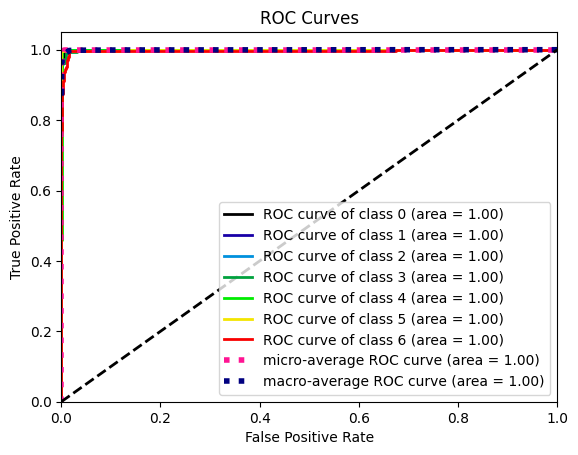

In [ ]:
from scikitplot.metrics import plot_roc, plot_precision_recall

plot_roc(y_test, probabilities)
plt.show();

## Saving and Loading The Model

In [ ]:
model.save_pretrained("./saved_model")

In [ ]:
with tpu_strategy.scope():
  loaded_model = TFAutoModelForSequenceClassification.from_pretrained("/content/saved_model")

Some layers from the model checkpoint at /content/saved_model were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


## Prediction

In [ ]:
text1 = "please play the most popular songs"
text2 = "I will give 0 star to the book I am reading now"
text3 = "Find me the best movies"
text4 = "I'd like to watch the best actor movie"
text5 = "Need to make a reservation for 4."

reviews = [text1, text2, text3, text4, text5]

In [ ]:
samples=[]
for i in reviews:
  samples.append({"text": str(i)})

In [ ]:
def prep_data(samples, model):
  from datasets import Dataset
  samples_dataset = Dataset.from_list(samples)
  samples_tokenized_data = samples_dataset.map(transformation, batched=True)
  tf_dataset_samples = model.prepare_tf_dataset(samples_tokenized_data , batch_size=32, shuffle=False)
  return tf_dataset_samples

In [ ]:
tf_dataset_samples=prep_data(samples, loaded_model)

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
logits=loaded_model.predict(tf_dataset_samples)
logits

1/1 [==============================] - 9s 9s/step


TFSequenceClassifierOutput(loss=None, logits=array([[ 5.126729  , -0.7318055 , -1.7575041 , -0.6850482 , -1.1763637 ,
        -1.2705566 ,  0.5888716 ],
       [-1.3406272 , -0.52729106,  5.745605  , -1.0056387 , -0.6647007 ,
        -0.85411906, -1.1160775 ],
       [-1.1884226 , -1.3912234 , -0.90235764,  4.974998  , -1.0139041 ,
        -1.2907686 ,  1.6892112 ],
       [-0.89347947, -1.2407577 , -1.2357657 ,  3.4886253 , -1.3946481 ,
        -1.5515809 ,  3.4855962 ],
       [-0.9189498 , -1.5235736 , -0.9124363 , -0.8719808 ,  5.177753  ,
        -0.35983416, -0.76818866]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
probs= tf.nn.softmax(logits.logits, axis=1).numpy()
probs

array([[9.7937030e-01, 2.7965191e-03, 1.0026804e-03, 2.9303818e-03,
        1.7928685e-03, 1.6317032e-03, 1.0475637e-02],
       [8.2994933e-04, 1.8718846e-03, 9.9211746e-01, 1.1602065e-03,
        1.6315591e-03, 1.3500176e-03, 1.0388965e-03],
       [2.0077762e-03, 1.6392306e-03, 2.6727098e-03, 9.5379466e-01,
        2.3906047e-03, 1.8124542e-03, 3.5682552e-02],
       [6.1232885e-03, 4.3267696e-03, 4.3484224e-03, 4.8990139e-01,
        3.7096259e-03, 3.1708453e-03, 4.8841968e-01],
       [2.2177731e-03, 1.2115248e-03, 2.2322647e-03, 2.3244245e-03,
        9.8555619e-01, 3.8791613e-03, 2.5786464e-03]], dtype=float32)

In [ ]:
y_pred = np.argmax(probs, axis=1)
y_pred

array([0, 2, 3, 3, 4])

In [ ]:
label_dict

{'PlayMusic': 0,
 'AddToPlaylist': 1,
 'RateBook': 2,
 'SearchScreeningEvent': 3,
 'BookRestaurant': 4,
 'GetWeather': 5,
 'SearchCreativeWork': 6}

In [ ]:
classification(tf_dataset_samples)

1/1 [==============================] - 10s 10s/step


array([0, 2, 3, 3, 4])

In [ ]:
text1 = "please play the most popular songs"
text2 = "I will give 0 star to the book I am reading now"
text3 = "Find me the best movies"
text4 = "I'd like to watch the best actor movie"
text5 = "Need to make a reservation for 4."